In [10]:
import sys
print("Python Version:", sys.version)

Python Version: 3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]


In [11]:
#######################
# standard code block #
#######################

%config InlineBackend.figure_format = 'svg'

# auto reload imports that change
%load_ext autoreload
# only set to auto reload for marked imports
%autoreload 1

In [12]:
import pandas as pd

## Pull Data

### Connect to Database

In [13]:
from pymongo import MongoClient
%aimport credentials.cred
from credentials import cred


config = {
  'host': cred.mongo_host,
  'username': cred.mongo_user,
  'password': cred.mongo_pass,
  'authSource': cred.mongo_auth_db
}

# get a mongo client
client = MongoClient(**config)

# use the clean database
jre_clean = client.jre_clean
podcasts_clean = jre_clean.podcasts

### Get Podcasts from Podscribe

In [14]:
# query
ps_ep_mongo = list(
    podcasts_clean
    .find({'source':'podscribe'},{'_id':0, 'number':1, 'name':1, 'desc':1, 'text':1})
    .limit(200)
)

In [15]:
# pull out text and names
ps_ep_text_list = [ep['text'] for ep in ps_ep_mongo]
ps_ep_list = [' '.join([x['text'] for x in ep]) for ep in ps_ep_text_list]
ps_ep_names = [f"#{x['number']} " + x['name'] for x in ps_ep_mongo]
ps_ep_descs = [x['desc'] for x in ps_ep_mongo]

## EDA

### Chunked Sentiment Analysis

In [2]:
from textblob import TextBlob
from copy import deepcopy

In [13]:
ps_ep_textblob = []

for ep in ps_ep_list:
    ps_ep_textblob.append(TextBlob(ep))

In [22]:
ps_ep_sentiment = []

for ep in ps_ep_textblob:
    ep_blob = []
    ep_blob.append(TextBlob(' '.join(ep.words[:1000])))
    ep_blob.append(TextBlob(' '.join(ep.words[1000:-1000])))
    ep_blob.append(TextBlob(' '.join(ep.words[-1000:])))
    ps_ep_sentiment.append(deepcopy(ep_blob))

In [23]:
sentiment_list = []

for ad1, body, ad2 in ps_ep_sentiment:
    sentiment = []
    sentiment.append(ad1.sentiment)
    sentiment.append(body.sentiment)
    sentiment.append(ad2.sentiment)
    sentiment_list.append(deepcopy(sentiment))

In [16]:
ep_sentiment_list = []

# episode sentiment [[episode 0 [timestamp0, polarity0, subjectivity0]]]
for ep in ps_ep_text_list:
    ep_sent = []
    
    for txt in ep:
        tblob = TextBlob(txt['text'])
        ep_sent.append([txt['time'], tblob.sentiment[0], tblob.sentiment[1]])
    ep_sentiment_list.append(deepcopy(ep_sent))

### Compare Chunks

In [18]:
import matplotlib.pyplot as plt

In [ ]:
x = [x for x in range(0,len(sentiment_list))]

y1_pol = [x[0].polarity for x in sentiment_list]
y1_sub = [x[0].subjectivity for x in sentiment_list]

y2_pol = [x[1].polarity for x in sentiment_list]
y2_sub = [x[1].subjectivity for x in sentiment_list]

y3_pol = [x[2].polarity for x in sentiment_list]
y3_sub = [x[2].subjectivity for x in sentiment_list]

In [39]:
import numpy as np

In [41]:
av_pol = (np.array(y1_pol) + np.array(y2_pol) + np.array(y3_pol))/3

/home/eric/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/home/eric/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/eric/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


<Figure size 432x288 with 0 Axes>

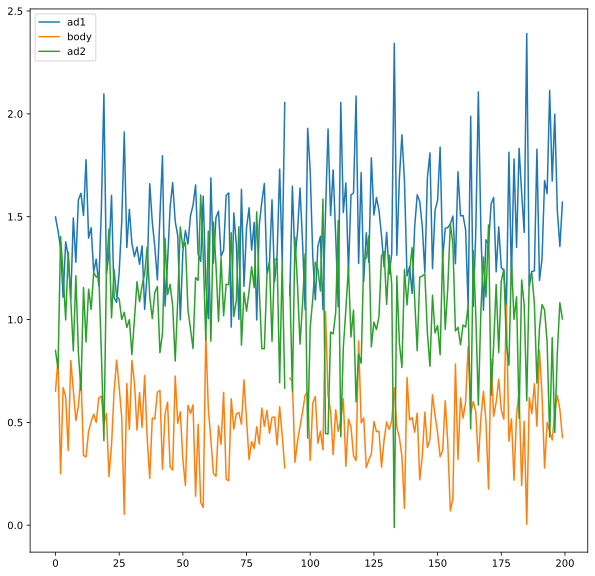

In [43]:
plt.suptitle('')
plt.figure(figsize=[10,10])

plt.plot(x,y1_pol/av_pol, label='ad1')
plt.plot(x,y2_pol/av_pol, label='body')
plt.plot(x,y3_pol/av_pol, label='ad2')
plt.legend()
plt.savefig('./reports/figures/ad_vs_body_sentiment.svg',bbox_inches='tight')